# Waterbodies Seasonal Animations

* **Products used:** [DE Africa Waterbodies](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html); [DE Africa WOfS](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html); [GeoMADs](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html); [CHIRPS](https://docs.digitalearthafrica.org/en/latest/data_specs/CHIRPS_specs.html)

## Background
The Digital Earth Africa Continental Waterbodies Monitoring Service identifies more than 700,000 water bodies from over three decades of satellite observations. This service maps persistent and seasonal water bodies and the change in their water surface area over time. Mapped water bodies may include, but are not limited to, lakes, ponds, man-made reservoirs, wetlands, and segments of some river systems. For more information on the waterbodies monitoring service, refer to the [Datasets notebook](../Datasets/Waterbodies.ipynb).

Often, it makes sense to visualise changes in waterbodies through time using animations. Animations are a form of exploratory analysis that can help illustrate repeating seasonal patterns. This notebook demonstrates how to generate animations for the time series component of waterbodies alongside summary data from Water Observations from Space, rainfall data, and true-colour imagery.

This notebook demonstrates the creation of animations for waterbodies over seasons, so that seasonal patterns can be identified and interpreted.

**Disclaimer: DE Africa Waterbodies Surface Area Change measures the wet surface area of waterbodies as estimated from satellites. This product does not measure depth, volume, purpose of the waterbody, nor the source of the water.**

## Description
This notebook demonstrates the generation of two animations for inspecting changes in water extent, drawing on the [DE Africa Waterbodies service](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html). 

Steps taken are:

1. Loading and preparing monthly time series, rolling GeoMAD, and rainfall data.
2. Creating an animation that shows monthly and seasonal changes in water extent for a selected waterbody.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import matplotlib.pyplot as plt
import datacube
import matplotlib.dates as mdates
import numpy as np
import matplotlib.animation as animation

from deafrica_tools.plotting import display_map
from IPython.display import HTML
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.waterbodies import (
    get_geohashes,
    get_waterbodies,
    get_waterbody,
    get_time_series,
    display_time_series,
)

In [2]:
dc = datacube.Datacube(app="Waterbody-anim")

## Analysis parameters

Next, an animation showing monthly progression of water extent will be produced. 

The default waterbody is [Mtera Reservoir in Tanzania](https://en.wikipedia.org/wiki/Mtera_Dam). This is a hydroelectric dam so water extent is somewhat under the influence of human decision-making.

In [3]:
# Set the central latitude and longitude
lat = -7.05
lon = 35.83

# Set the buffer to load around the central coordinates
buffer = 0.3

# Compute the bounding box coordinates
xlim = (lon - buffer, lon + buffer)
ylim = (lat + buffer, lat - buffer)

# Preview area on a map
display_map(xlim, ylim)

## Select waterbody

We use the same procedure as above to load available polygons within a specified area and select the waterbody of interest.

In [4]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")

# Explore the waterbody polygons located within the bounding box
polygons.explore()

### Inspect time series

The time series for the Mtera Reservoir shows some seasonal variation in water extent, often with with very large filling events followed by progressive contraction of water extent.

This time series is taken directly from the Waterbodies database and is linked to the waterbody geohash; in this case `ky9rzpq3c0` as we see when hovering over the polygon in the explorer above. More information on the Waterbodies service and time series can be found in the [Datasets notebook](../Datasets/Waterbodies.ipynb) and in the [documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html).

In [5]:
selected_waterbody_geohash = "ky9rzpq3c0"
selected_waterbody = get_waterbody(selected_waterbody_geohash)

# Get time series for the selected water body
selected_waterbody_timeseries = get_time_series(waterbody=selected_waterbody)

display_time_series(selected_waterbody_timeseries)

### Prepare time series for plotting

The water extent time series needs to be prepared for inclusion in the animation, as below.

In [6]:
tsw = (
    selected_waterbody_timeseries.percent_wet.loc["2019-01-15":"2023-08-31"]
    .resample("1M")
    .mean()
    .interpolate()
)

### Load rolling GeoMAD

For this animation, we are interested in seasonal variation in water extent and land surface condition, so we are using the 3-monthly rolling geomedian at monthly timesteps. The rolling GeoMAD for the relevant period and extent is loaded below, with the red, green, and blue bands loaded for true colour visualisation.

In [7]:
lat_range = (selected_waterbody.total_bounds[1], selected_waterbody.total_bounds[3])
lon_range = (selected_waterbody.total_bounds[0], selected_waterbody.total_bounds[2])

ds = dc.load(
    product=["gm_s2_rolling"],
    measurements=["red", "green", "blue"],
    x=lon_range,
    y=lat_range,
    resolution=(-30, 30),
    dask_chunks={"time": 1, "x": 3000, "y": 3000},
    time=("2019-02-01", "2023-08-31"),
).compute()

### Load monthly rainfall

Plotting monthly rainfall alongside water extent assists in understanding seasonal patterns in waterbody state. The cell below loads monthly rainfall from CHIRPS and prepares it as a time series data frame by dropping the spatial dimensions.

In [8]:
ds_rf = dc.load(
    product="rainfall_chirps_monthly",
    measurements=["rainfall"],
    x=lon_range,
    y=lat_range,
    time=("2019-01-01", "2023-08-31"),
)

ds_rf_month = ds_rf.mean(["longitude", "latitude"]).to_dataframe().drop(["spatial_ref"], axis=1)

### Develop time series and rainfall chart

For this animation, rainfall and surface water extent will be presented alongside a true colour representation of the waterbody. 

To present rainfall and surface extent, we follow conventions of the [hydrograph](https://www.futurelearn.com/info/courses/urban-stormwater-management-in-a-changing-climate/0/steps/349504) which is traditionally used to display rainfall and runoff. A unique convention is that rainfall is presented on a reversed secondary y-axis, that is, falling from the top.

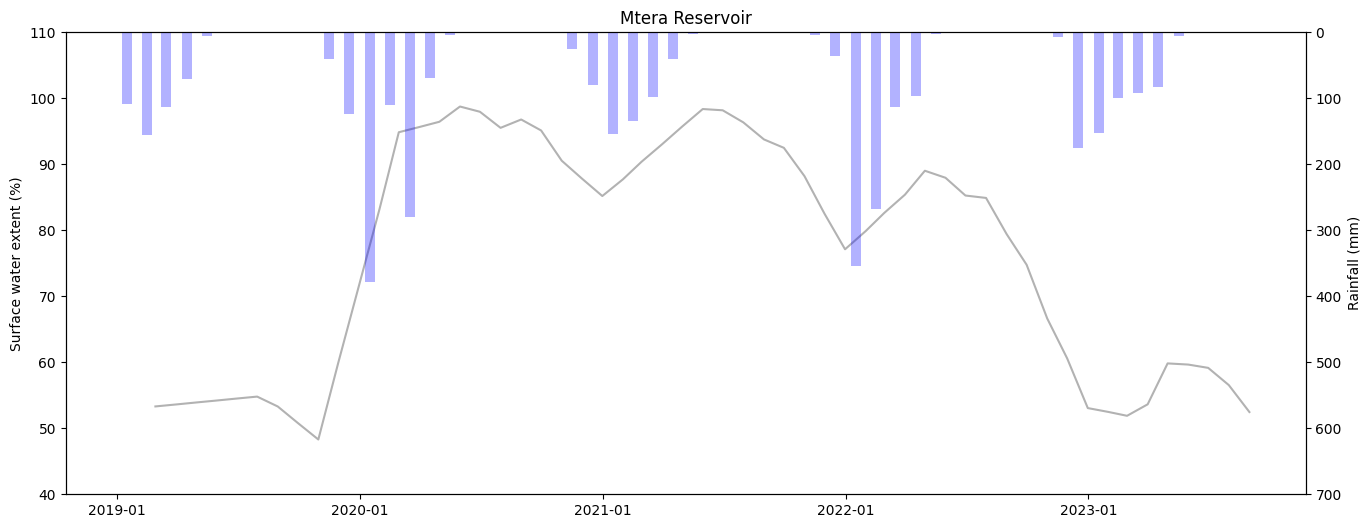

In [9]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax2 = ax1.twinx()
ax2.set_ylim([0,700])
ax2.invert_yaxis()
ax2.bar(ds_rf_month.index, ds_rf_month.rainfall, width=15, align="center", color="b", alpha=0.3)
ax2.set_ylabel("Rainfall (mm)")

ax1.plot(tsw, color="k", alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.set_ylim([40,110])
ax1.set_ylabel("Surface water extent (%)")

plt.title("Mtera Reservoir");

### Check time series length

This cell prints the length of the time series for:
* Rainfall
* Water extent time series
* Geomedian imagery

To ensure the length is uniform and frames of the animation will match.

In [10]:
print(len(ds_rf_month.index))
print(len(tsw.index))
print(len(ds.time))

55
55
55


## Generate seasonal animation

Finally, we run the animation. The block of code below prepares the figure layout then defines starting data to be presented. The update function displays new data for each component of the animation at a common interval.

The animation output can be saved and then downloaded by uncommenting (removing the `#`) the command `ani.save('MteraReservoir.gif')`.

In [11]:
# create a figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)

ax1.set_title("Monthly rainfall and water extent")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Precipitation (mm)")

bands = ["red", "green", "blue"]


cax = (
    ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze()
    / np.max(ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze())
).plot.imshow(rgb="variable", animated=True, robust=True)

ax3 = ax1.twinx()
bars = ax3.bar(ds_rf_month.index, ds_rf_month.rainfall * [0], width=15, align="center", color="b")
ax3.bar(ds_rf_month.index, ds_rf_month.rainfall, width=15, align="center", color="b", alpha=0.2)
ax3.set_ylabel("Rainfall (mm)")
ax3.set_ylim(0, np.max(ds_rf_month.rainfall) + 20)
ax3.set_ylim([0,700])
ax3.invert_yaxis()

x = tsw.index
y = tsw.values

(line,) = ax1.plot(x, y, color="k")
ax1.plot(x, y, color="k", alpha=0.2)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.tick_params(axis="x", labelrotation=45)
ax1.set_ylim([40,110])
ax1.set_ylabel("Surface water extent (%)")


def update(num, x, y, bars, line):
    cax.set_array(
        (
            ds[bands]
            .isel(time=num)
            .to_array()
            .transpose("y", "x", "variable")
            .squeeze()
            .clip(0, 2500)
            / np.max(
                ds[bands]
                .isel(time=num)
                .to_array()
                .transpose("y", "x", "variable")
                .squeeze()
                .clip(0, 2500)
            )
        )
    )
    ax2.set_title("Time = " + str(ds[bands].coords["time"].values[(num)])[:12])
    bars[num].set_height(ds_rf_month.rainfall.iloc[num])
    line.set_data(x[:num], y[:num])
    return (line,)


plt.tight_layout()

ani = animation.FuncAnimation(
    fig, update, len(x), fargs=[x, y, bars, line], interval=300, blit=True
)
# ani.save('MteraReservoir.gif')

plt.close()
HTML(ani.to_html5_video())

## Bakolori Dam

Next, we'll generate another animation for a lake with distinctly seasonal behaviour. The Bakolori Dam is on the Sokoto River in the Niger River basin, in northern Nigeria. It's development, maintenance, and use [have been controversial](https://www.sciencedirect.com/science/article/abs/pii/0305750X9390121O).

The animation produced in this notebook show seasonal patterns in surface water extent for the dam.

The cells below follow a similar process to that shown above for Mtera Reservoir, with few outputs presented along the way for brevity.

### Select the polygon

In [12]:
# Set the central latitude and longitude
lat = 12.53
lon = 6.22

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box coordinates
xlim = (lon - buffer, lon + buffer)
ylim = (lat + buffer, lat - buffer)

# Preview area on a map
display_map(xlim, ylim)

In [13]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")

# Explore the waterbody polygons located within the bounding box
polygons.explore()

### Inspect time series

The plot below shows an obvious seasonal wetting and drying pattern from 2013 when there is sufficient data coverage.

In [14]:
selected_waterbody_geohash = "s4hrjw1qx8"
selected_waterbody = get_waterbody(selected_waterbody_geohash)

# Get time series for the selected water body
selected_waterbody_timeseries = get_time_series(waterbody=selected_waterbody)

display_time_series(selected_waterbody_timeseries)

### Load rolling GeoMAD

In [15]:
lat_range = (selected_waterbody.total_bounds[1], selected_waterbody.total_bounds[3])
lon_range = (selected_waterbody.total_bounds[0], selected_waterbody.total_bounds[2])

ds = dc.load(
    product=["gm_s2_rolling"],
    measurements=["red", "green", "blue"],
    x=lon_range,
    y=lat_range,
    resolution=(-30, 30),
    dask_chunks={"time": 1, "x": 3000, "y": 3000},
    time=("2019-01-15", "2023-08-31"),
).compute()

### Rainfall data

The cell below obtains rainfall data from CHIRPS and converts it to a monthly time series. 

Then, the length of the time series for each data is printed to ensure uniformity.

In [16]:
ds_rf = dc.load(
    product="rainfall_chirps_monthly",
    measurements=["rainfall"],
    x=lon_range,
    y=lat_range,
    time=("2019-01-15", "2023-08-31"),
)

ds_rf_month = ds_rf.mean(["longitude", "latitude"]).to_dataframe().drop(["spatial_ref"], axis=1)

tsw = (
    selected_waterbody_timeseries.percent_wet.loc["2019-01-15":"2023-08-31"]
    .resample("1M")
    .mean()
    .interpolate()
)

print(len(ds_rf_month.index))
print(len(tsw.index))
print(len(ds.time))

55
55
55


## Create animation for Bakolori Dam

This cell produces the animation. The output can be saved as a .gif by removing the # and running the `ani.save('BakoloriDam.gif')` command.

In [17]:
# create a figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)

ax1.set_title("Monthly rainfall and water extent")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Precipitation (mm)")

bands = ["red", "green", "blue"]

cax = (
    ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze()
    / np.max(ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze())
).plot.imshow(rgb="variable", animated=True, robust=True)

ax3 = ax1.twinx()
bars = ax3.bar(ds_rf_month.index, ds_rf_month.rainfall * [0], width=15, align="center", color="b")
ax3.bar(ds_rf_month.index, ds_rf_month.rainfall, width=15, align="center", color="b", alpha=0.2)
ax3.set_ylabel("Rainfall (mm)")
ax3.set_ylim(0, np.max(ds_rf_month.rainfall) + 20)
ax3.set_ylim([0,700])
ax3.invert_yaxis()

x = tsw.index
y = tsw.values

(line,) = ax1.plot(x, y, color="k")
ax1.plot(x, y, color="k", alpha=0.2)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.tick_params(axis="x", labelrotation=45)
ax1.set_ylim([15,120])
ax1.set_ylabel("Surface water extent (%)")

def update(num, x, y, bars, line):
    cax.set_array(
        (
            ds[bands]
            .isel(time=num)
            .to_array()
            .transpose("y", "x", "variable")
            .squeeze()
            / np.max(
                ds[bands]
                .isel(time=num)
                .to_array()
                .transpose("y", "x", "variable")
                .squeeze()
            )
        )
    )
    ax2.set_title("Time = " + str(ds[bands].coords["time"].values[(num)])[:12])
    bars[num].set_height(ds_rf_month.rainfall.iloc[num])
    line.set_data(x[:num], y[:num])
    return (line,)

plt.tight_layout()

ani = animation.FuncAnimation(
    fig, update, len(x), fargs=[x, y, bars, line], interval=500, blit=True
)
# ani.save('BakoloriDam.gif')

plt.close()
HTML(ani.to_html5_video())

## Conclusion

This notebook has demonstrated two animations for visualising waterbodies over different periods. The techniques and code shown here can be adapted to user defined purposes. These visualisations can be useful for exploratory analysis of trends in water extent over several years, or seasonal patterns in water extent and relationships with rainfall patterns. More formal trend and pattern analysis would need to be undertaken to better understand these phenomena.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [18]:
import datacube

print(datacube.__version__)

1.8.19


**Last Tested:**

In [19]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2024-11-25'